In [1]:
import os
import numpy as np
import pandas as pd
import mplhep as hep
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText

os.chdir('..')

from parameters import PtBinning, AK8TaggerWP

hep.style.use(hep.style.ROOT) # For now ROOT defaults to CMS

In [2]:
folders = {
    '2016-PreVFP'  : '2016ULPre-VFP_FIXED_fixbkg',
    '2016-PostVFP' : '2016ULPost-VFP_FIXED_fixbkg',
    '2017'         : '2017UL_FIXED_fixbkg_v02',
    '2018'         : '2018UL_FIXED_fixbkg_v02'
}

outdir = "/work/mmarcheg/BTVNanoCommissioning/plots/UltraLegacySF"

if not os.path.exists(outdir):
    os.makedirs(outdir)

filename = "/work/mmarcheg/BTVNanoCommissioning/fitdir/2016ULPre-VFP/msd100tau06btagDDCvLV2Hwp/fitResultsHwp.csv"
df = pd.read_csv(filename, usecols=['year', 'campaign', 'selection', 'wp', 'pt', 'c_cc', 'c_ccErrUp', 'c_ccErrDown'])
df = df[df['pt'] != 'Inclusive']
df

,year,campaign,selection,wp,pt,c_cc,c_ccErrUp,c_ccErrDown
1,2016,UL,msd100tau06,H,L,1.076111,0.923889,1.076111
2,2016,UL,msd100tau06,H,M,1.038275,0.107033,0.106758
3,2016,UL,msd100tau06,H,H,0.985663,0.165914,0.157367


In [3]:
df[df['pt'] == 'M']['c_cc'].values[0]

1.0382752488978335

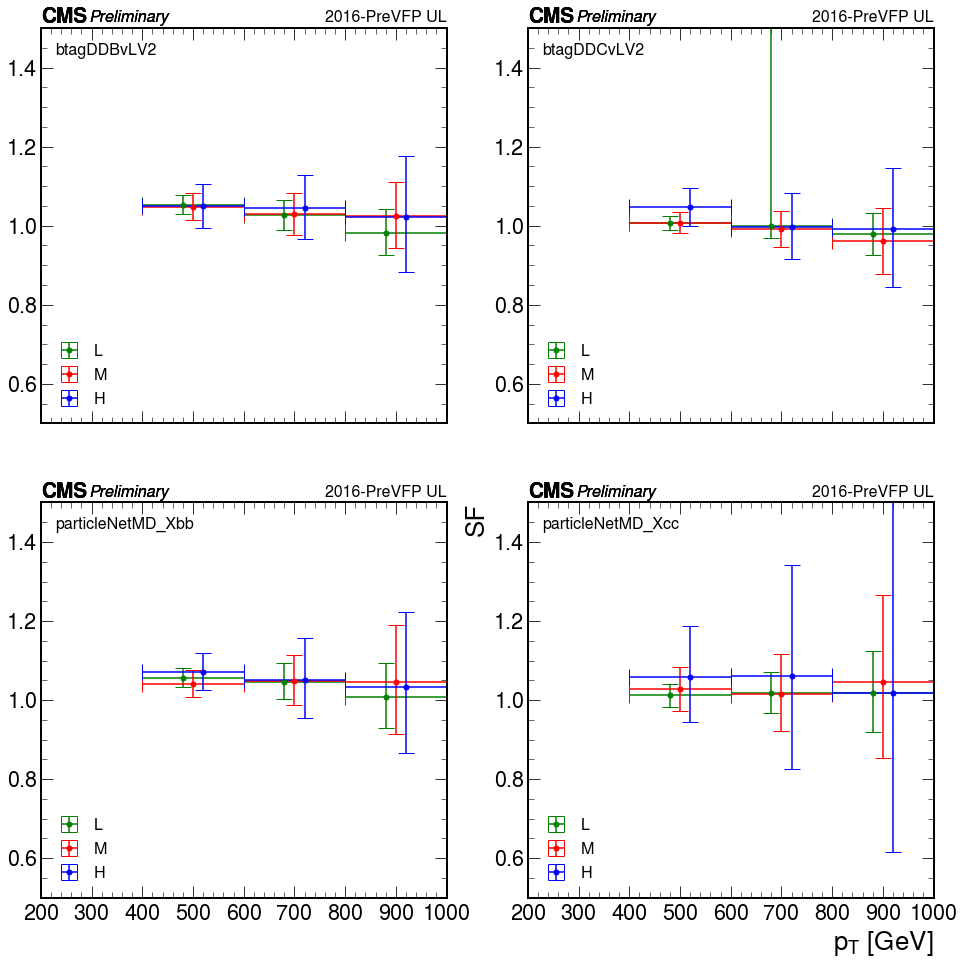

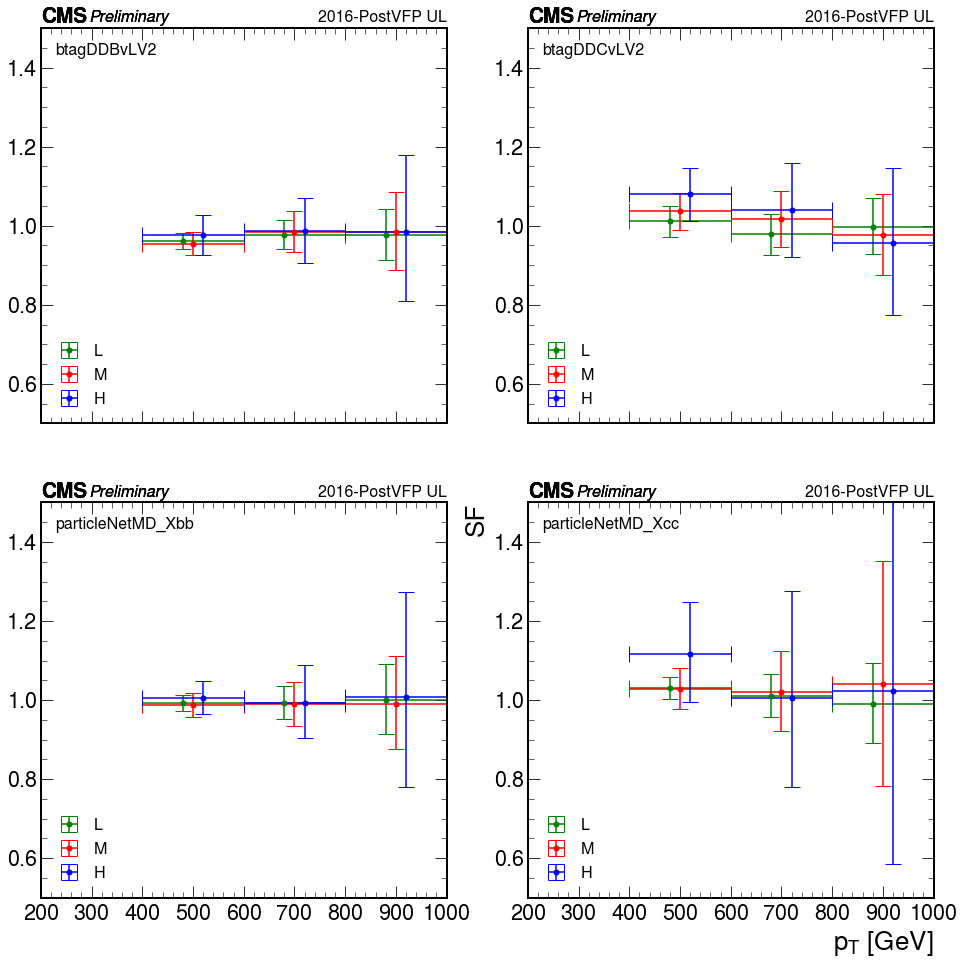

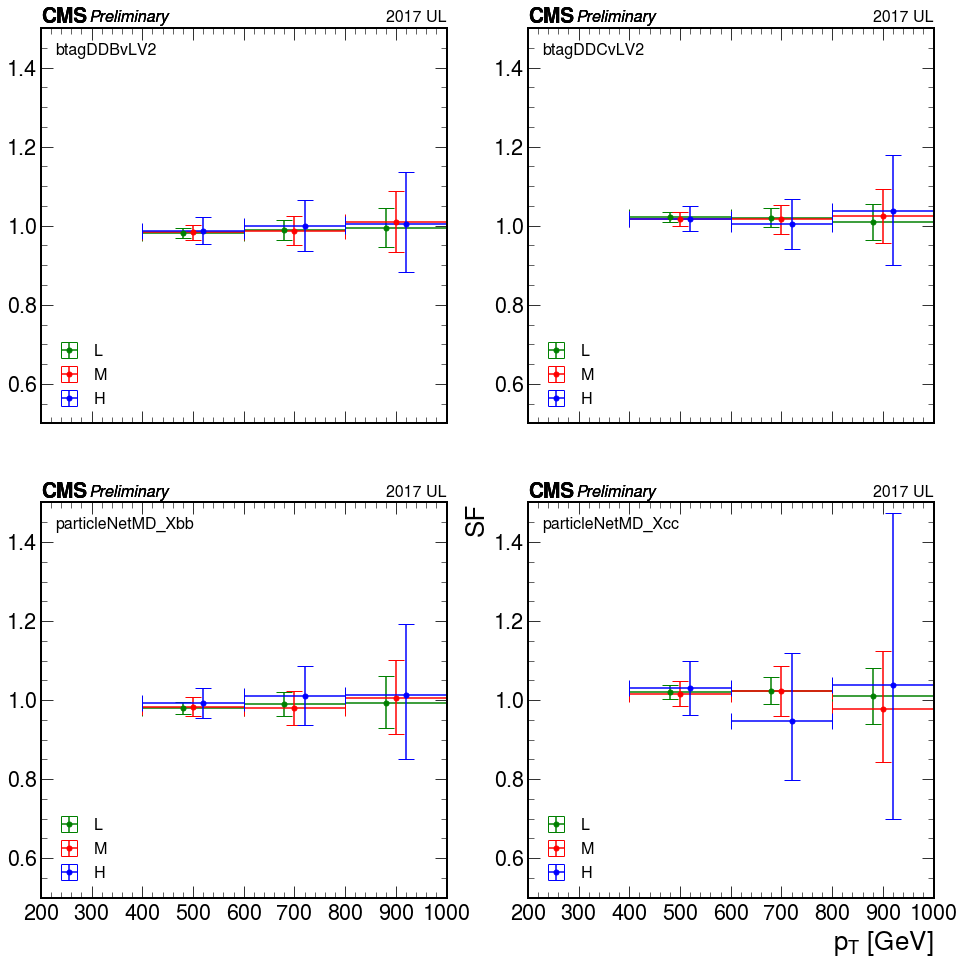

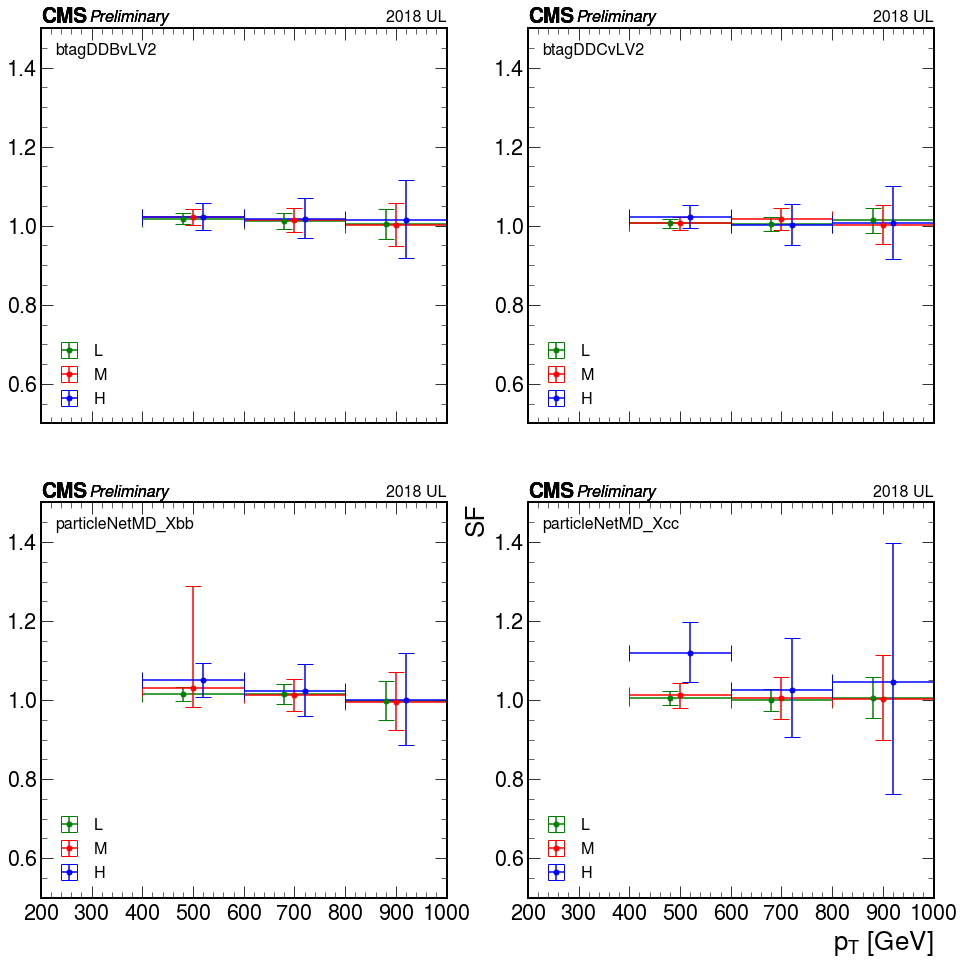

In [7]:
fontsize = 16
verbose = False

pt_offset = {
    'L' : -20,
    'M' : 0,
    'H' : 20
}

wp_color = {
    'L' : 'green',
    'M' : 'red',
    'H' : 'blue',
}

for key in folders.keys():
#for key in ['2016-PreVFP']:
    folder = folders[key]
    year = key.split('-')[0]
    fig, axes = plt.subplots(2,2, figsize=[16,16], sharex=True)
    plt.xlim(200, 1000)
    plt.ylim(0.6, 1.3)
    plt.xticks(np.arange(200, 1100, 100))
    plt.xlabel(r"p$_T$ [GeV]")
    plt.ylabel("SF")
    for i, tagger in enumerate(AK8TaggerWP['UL'][year].keys()):
        text = tagger
        at = AnchoredText(text, loc='upper left', prop={'fontsize' : fontsize}, frameon=False)
        axes[int(i/2)][i%2].add_artist(at)
        if verbose:
            print(tagger)
        for wp in [ 'L', 'M', 'H' ]:
            
            SF = None
            SFerr = None

            if ('DDC' in tagger) | ('Xcc' in tagger):
                POI = 'c_cc'
            elif ('DDB' in tagger) | ('Xbb' in tagger):
                POI = 'b_bb'

            filename = f"/work/mmarcheg/BTVNanoCommissioning/fitdir/{folder}/msd100tau06{tagger}{wp}wp/fitResults{wp}wp.csv"
            #df = pd.read_csv(filename)
            #print(df)
            df = pd.read_csv(filename, usecols=['year', 'campaign', 'selection', 'wp', 'pt', f'{POI}', f'{POI}ErrUp', f'{POI}ErrDown'])
            #try: df = pd.read_csv(filename, usecols=['year', 'campaign', 'selection', 'wp', 'pt', f'{POI}', f'{POI}ErrUp', f'{POI}ErrDown'])
            #except: print(filename)
            df = df[df['pt'] != 'Inclusive']
            if verbose:
                print(df)

            year = str(df['year'].values[0])
            campaign = df['campaign'].values[0]
            axes[int(i/2),i%2].set_title(f'{key} {campaign}', loc='right', fontsize=fontsize)
            hep.cms.text("Preliminary", ax=axes[int(i/2),i%2], loc=0, fontsize=fontsize)
            ptbinning = PtBinning[campaign][year]

            #SF = df[POI].values
            #SFerr = np.array( (df[f'{POI}ErrDown'].values, df[f'{POI}ErrUp'].values) )

            pt = []
            #pterr = []
            pterrDown = []
            pterrUp = []
            SF = []
            SFerrDown = []
            SFerrUp = []
            for wpt in ptbinning.keys():
                if wpt == 'M+H': continue
                pt_low, pt_high = ptbinning[wpt]
                if 'H' in wpt:
                    pt_center = 900
                else:
                    pt_center = np.mean((pt_low, pt_high))
                #pt_err = pt_center - pt_low
                pt_err_down = pt_center - pt_low + pt_offset[wp]
                pt_err_up = pt_center - pt_low - pt_offset[wp]
                pt.append(pt_center + pt_offset[wp])
                #pterr.append(pt_err)
                pterrDown.append(pt_err_down)
                pterrUp.append(pt_err_up)
                SF.append( df[df['pt'] == wpt][POI].values[0] )
                SFerrDown.append( df[df['pt'] == wpt][f'{POI}ErrDown'].values[0] )
                SFerrUp.append( df[df['pt'] == wpt][f'{POI}ErrUp'].values[0] )
            pterr = np.array( (np.array(pterrDown), np.array(pterrUp)) )
            SFerr = np.array( (np.array(SFerrDown), np.array(SFerrUp)) )
                
            if len(SF) != len(pt):
                print(f"\n{year}{campaign} {tagger} {wp} WP: {len(pt) - len(SF)} datapoints are missing. Available pt:", end='')
                print(df['pt'].values, end='\n\n')
                continue
            
            axes[int(i/2),i%2].errorbar(pt, SF, xerr=pterr, yerr=SFerr, capsize=8, linestyle='', marker='o', markersize=5, color=wp_color[wp], label=wp)
            axes[int(i/2),i%2].set_ylim(0.5, 1.5)
        axes[int(i/2),i%2].legend(loc="lower left", fontsize=fontsize)
        #plt.show()
        #axes[i/2,i%2].close()
    plt.savefig(os.path.join(outdir, f"SF_UL_{key}.png"), dpi=400, format="png")
    plt.show()
    plt.close()